# Wine data analysis. Model predicting median wine score.

Import the necessary libraries.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
plt.style.use('ggplot')

Read and show the data.

In [83]:
df = pd.read_csv('WINE.csv', sep=',')
df

,Index,Target,Type,Alcohol,Density,Nitrogen,pH,Sugar,A,B,C,D,Di,E,H,S,U,V
0,0,3,white_wine,7.50,1.02,7.51,3.19,10.85,25.1,1.98,10.20,39.6,49.10,1.37,2.36,2.34,6.35,0.29
1,1,4,white_wine,7.65,1.02,3.41,3.40,1.54,23.9,1.58,4.20,38.5,48.16,0.94,2.42,3.07,7.65,0.05
2,2,3,red_wine,8.10,1.02,0.25,3.76,2.11,21.7,7.92,0.30,22.0,34.93,1.26,4.84,4.38,4.40,0.22
3,3,4,white_wine,8.80,1.01,6.35,3.11,3.82,24.3,1.45,4.20,16.5,33.77,1.01,1.49,8.18,3.60,0.10
4,4,3,red_wine,7.80,1.02,5.34,3.51,3.25,27.3,5.15,4.50,31.9,40.26,1.57,4.15,4.53,6.45,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,5595,5,white_wine,9.40,1.01,4.67,3.10,3.44,22.5,3.70,4.05,13.2,25.55,1.62,1.43,6.86,3.35,0.07
5596,5596,5,white_wine,8.95,1.01,4.33,3.58,3.06,22.9,2.11,4.65,44.0,59.84,1.65,1.80,6.42,5.40,0.13
5597,5597,4,white_wine,9.40,1.01,4.85,3.64,3.82,21.3,2.24,3.90,18.7,36.25,1.28,1.74,4.09,5.45,0.19
5598,5598,4,white_wine,7.45,1.02,13.77,3.27,15.03,23.7,1.98,4.35,60.5,70.11,1.37,3.97,2.77,8.35,0.12


Split the train data.

In [20]:
X_train = np.array(pd.read_csv('WINE.csv', sep=',',header=0))
Y_train = X_train[:,1]
X_train = X_train[:,2:]
print(X_train)
print(X_train.shape)
print(Y_train)

[['white_wine' 7.5 1.02 ... 2.34 6.35 0.29]
 ['white_wine' 7.65 1.02 ... 3.07 7.65 0.05]
 ['red_wine' 8.1 1.02 ... 4.38 4.4 0.22]
 ...
 ['white_wine' 9.4 1.01 ... 4.09 5.45 0.19]
 ['white_wine' 7.45 1.02 ... 2.77 8.35 0.12]
 ['white_wine' 9.5 1.01 ... 2.19 5.85 0.19]]
(5600, 16)
[3 4 3 ... 4 4 4]


Show a frequency of the score.

Counter({3: 1858, 4: 2445, 5: 931, 6: 158, 2: 183, 1: 25})

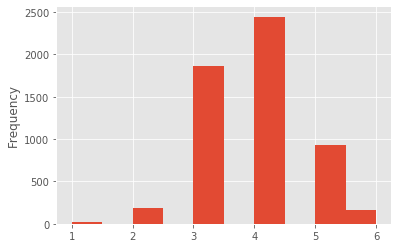

In [7]:
%matplotlib inline
s = pd.Series(Y_train)
s.plot.hist()
c = Counter(Y_train)
c

Show a frequency of the both categorical data - red and white wine.

In [4]:
c = Counter(X_train[:,0])
c

Counter({'white_wine': 4228, 'red_wine': 1372})

Box plot on each feature to detect the outliers.

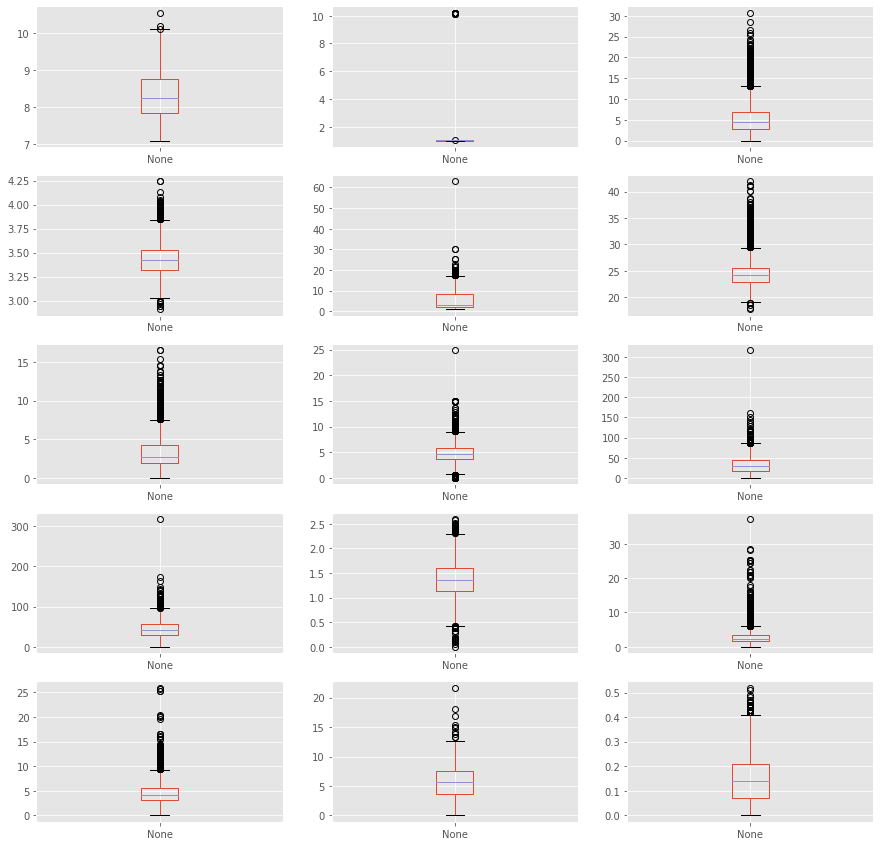

In [8]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,15))
s = []
for i in range(1, 16):
    s.append(pd.Series(X_train[:,i]))
for i in range(0, 5):
    for j in range(0, 3):
        s[j + 3*i].plot.box(ax=axes[i,j])

We see some outliers on several features. Especial one is feature number two. Based on the description of the data, we see that it's the liquid density. So the density of wine can't be equal $10$ $\frac{g}{m^3}$. We can conclude that it's a human mistake, therefore we must exclude rows including such values from the dataset. Below is a function that excludes the outliers.

In [21]:
def clear_ind(X, ind):
    s = pd.Series(X)
    Q1 = s.quantile(.25)
    Q3 = s.quantile(.75)
    k = 3
    X1 = Q1-k*(Q3-Q1)
    X3 = Q3+k*(Q3-Q1)
    i = 0
    for it in X:
        if it < X1 or it > X3:
            ind.append(i)
        i = i + 1
    return ind

Exclude rows with the most suspicious outliers.

In [22]:
#print(X_train)
ind = []
#for i in range(1, 16):
#    ind = clear_ind(X_train[:, i], ind)
ind = clear_ind(X_train[:, 2], ind)
ind = clear_ind(X_train[:, 5], ind)
ind = clear_ind(X_train[:, 8], ind)
ind = clear_ind(X_train[:, 9], ind)
ind = clear_ind(X_train[:, 10], ind)
ind = list(set(ind))
ind.sort()
X_train = np.delete(X_train, ind, axis=0)
Y_train = np.delete(Y_train, ind, axis=0)
print(len(X_train))
print(len(Y_train))

5561
5561


Plot a histogram of the score frequency after removing the outliers.

Counter({3: 1848, 4: 2427, 5: 929, 6: 158, 2: 177, 1: 22})

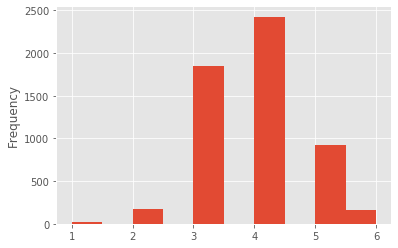

In [11]:
s = pd.Series(Y_train)
s.plot.hist()
c = Counter(Y_train)
c

Plot probability density functions for each feature, for red and white wine separately.

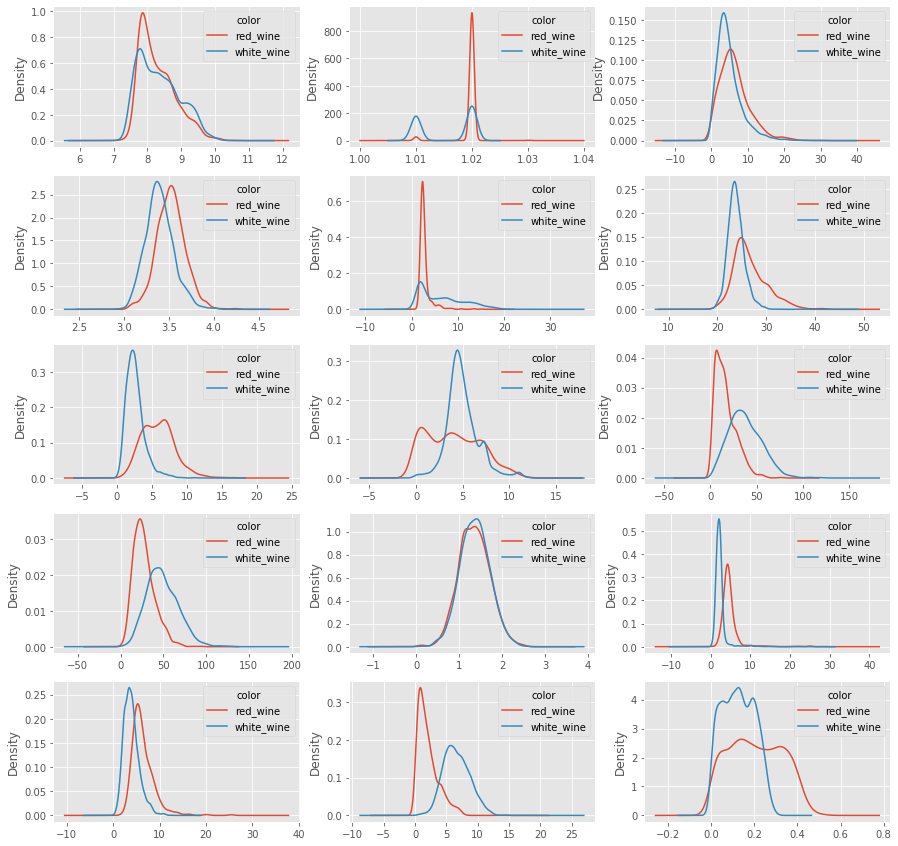

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,15))
df = []
for i in range(1, 16):
    df1 = pd.DataFrame({'color': X_train[:, 0], 'x': X_train[:, i]})
    df1 = df1.pivot(columns='color', values='x')
    df.append(df1)
for i in range(0, 5):
    for j in range(0, 3):
        df[j + 3*i].plot.kde(ax=axes[i,j])

Plot probability density function of score for red and white wine separately.

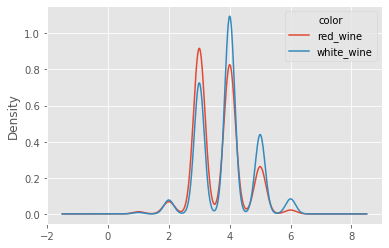

In [46]:
df = pd.DataFrame({'color': X_train[:, 0], 'x': Y_train})
df = df.pivot(columns='color', values='x')
df.plot.kde()

Plot a Seaborn heatmap that is correlation matrix for each feature.

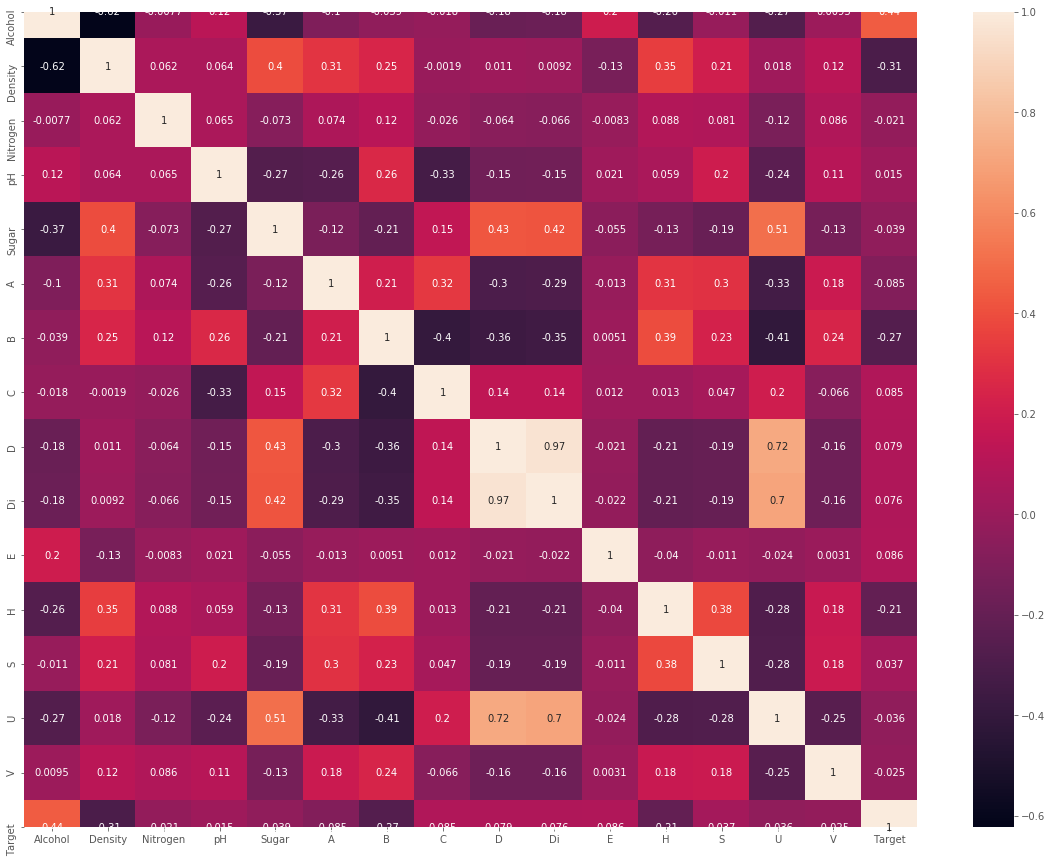

In [23]:
df = pd.DataFrame(X_train)
df['Target'] = Y_train
df.columns = ['Type','Alcohol','Density','Nitrogen','pH','Sugar','A','B','C','D','Di','E','H','S','U','V','Target']
plt.subplots(figsize=(20,15))
corr = df.loc[:,'Alcohol':].astype('float32').corr()
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Plot a Seaborn heatmap for red wine.

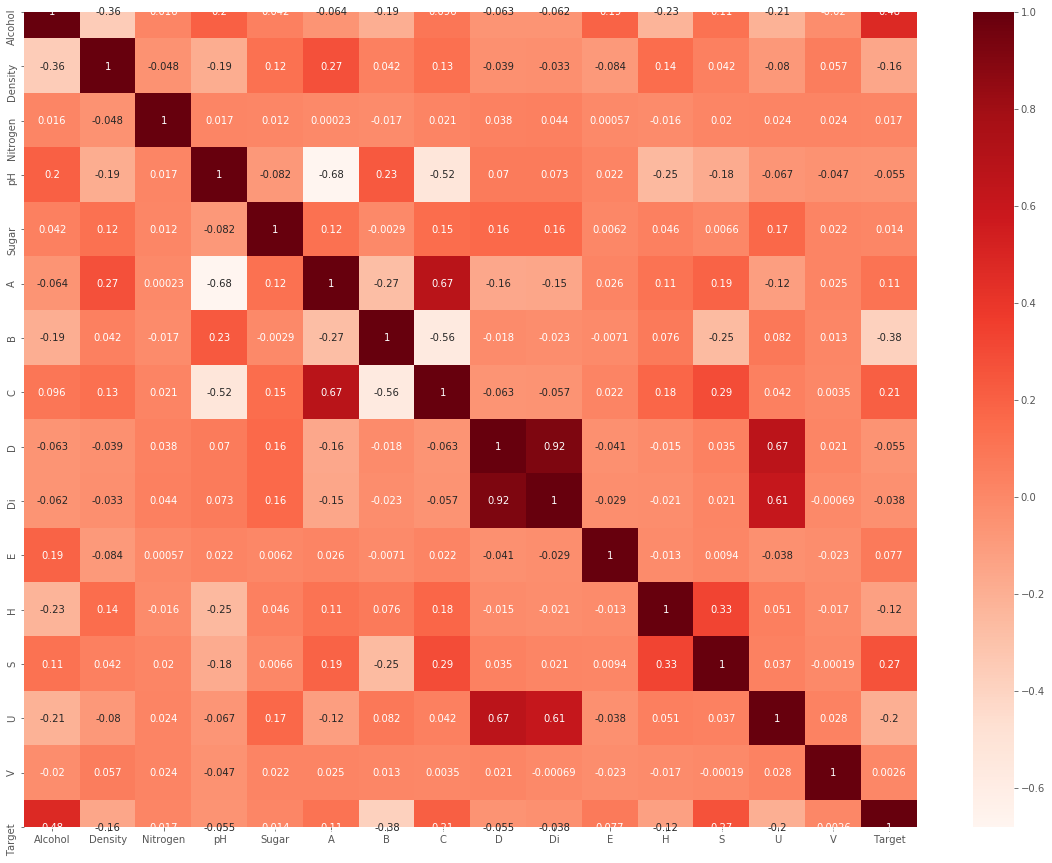

In [80]:
dfr = df.loc[df['Type'] == 'red_wine']
plt.subplots(figsize=(20,15))
corrr = dfr.loc[:,'Alcohol':].astype('float32').corr()
sns.heatmap(corrr, annot=True, xticklabels=corrr.columns.values,
            yticklabels=corrr.columns.values, cmap = "Reds")

Plot a Seaborn heatmap for white wine.

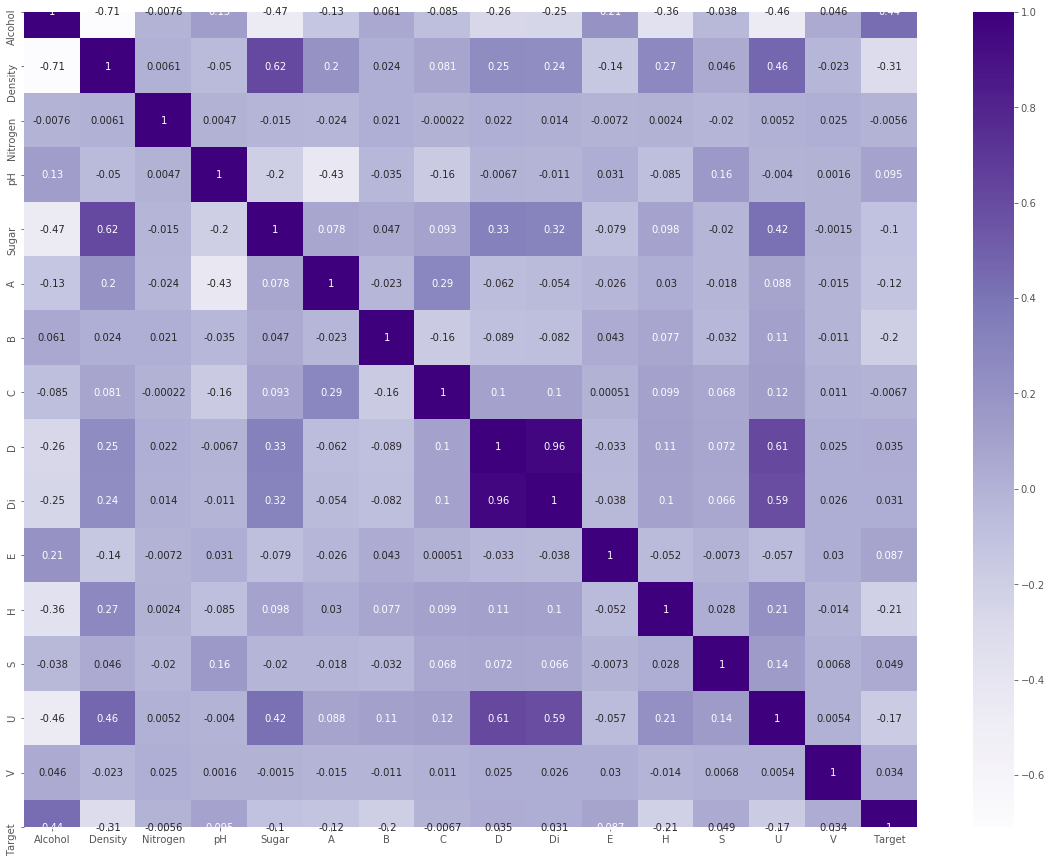

In [79]:
dfw = df.loc[df['Type'] == 'white_wine']
plt.subplots(figsize=(20,15))
corrw = dfw.loc[:,'Alcohol':].astype('float32').corr()
sns.heatmap(corrw, annot=True, xticklabels=corrw.columns.values,
            yticklabels=corrw.columns.values, cmap="Purples")

Plot a Seaborn heatmap for difference of red and white wine.

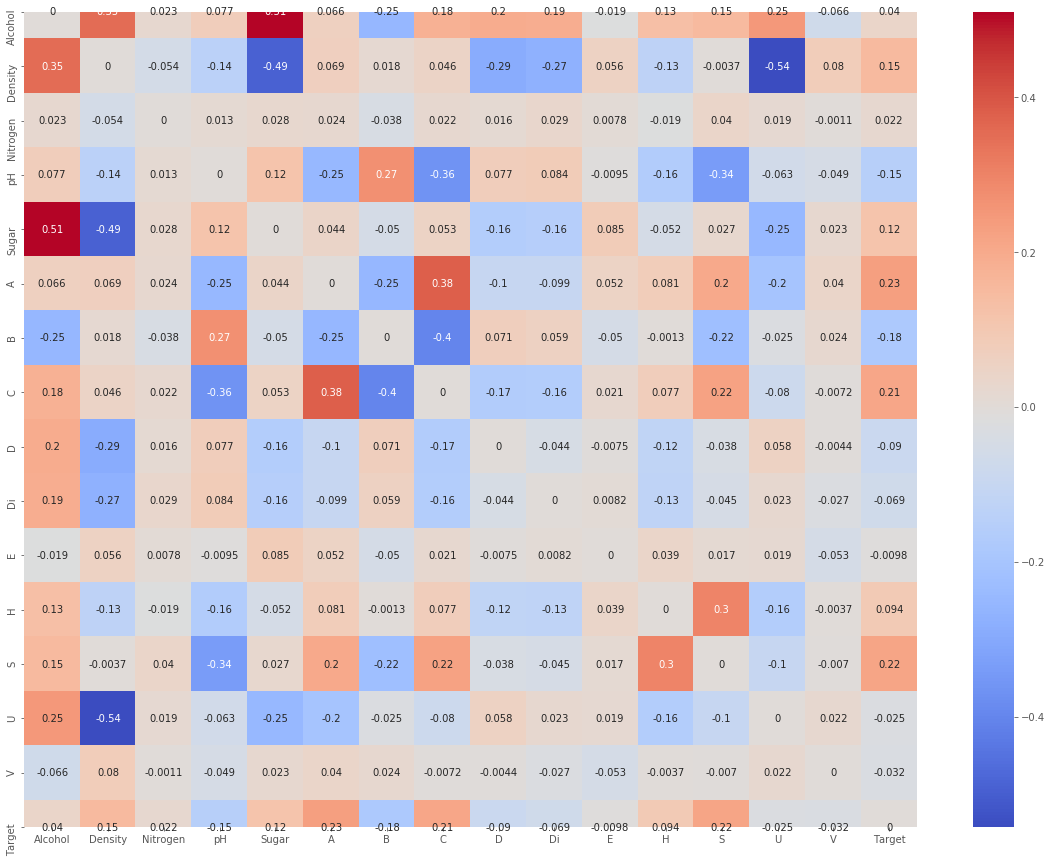

In [82]:
corr_dif = corrr-corrw
plt.subplots(figsize=(20,15))
sns.heatmap(corr_dif, annot=True, xticklabels=corr_dif.columns.values,
            yticklabels=corr_dif.columns.values, cmap="coolwarm")

We see a really high linear dependence between features named D and Di. Let's check out scatter plot of it.

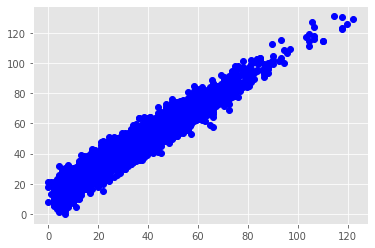

In [83]:
plt.plot(df['D'], df['Di'], 'bo')

So we can delete one of those columns from the dataset.

In [24]:
X_train = np.delete(X_train, np.s_[10], 1)

Also, we need to replace categorical variables to numeric variables. we can do it using method named One Hot Encoding.

In [25]:
X_train = np.delete(X_train, np.s_[0], 1)
X_train = np.column_stack((X_train, np.array(pd.get_dummies(df['Type']))))

Check shape of the features.

In [26]:
X_train.shape

(5561, 16)

Take the cube root of the all features to compress the data. It helps some algorithms work.

In [27]:
for i in range(0, 5561):
    for j in range(0, 14):
        X_train[i, j] = np.cbrt(X_train[i, j])
X_train

array([[1.9574338205844317, 1.006622709560113, 1.9583034048039198, ...,
        0.6619105948026229, 0, 1],
       [1.9703973362613048, 1.006622709560113, 1.5051673636460965, ...,
        0.3684031498640387, 0, 1],
       [2.0082988502465087, 1.006622709560113, 0.6299605249474365, ...,
        0.6036810736797686, 1, 0],
       ...,
       [2.11045429449015, 1.0033222835420892, 1.6927022813721821, ...,
        0.574889707894483, 0, 1],
       [1.9530742653487878, 1.006622709560113, 2.3968709221362037, ...,
        0.493242414866094, 0, 1],
       [2.1179117921274466, 1.0033222835420892, 0.954640270936004, ...,
        0.574889707894483, 0, 1]], dtype=object)

Normalize the data to interval $[0, 1]$

In [28]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [29]:
X_train

array([[0.13064981, 0.50163402, 0.62527765, ..., 0.82312328, 0.        ,
        1.        ],
       [0.17844465, 0.50163402, 0.48059331, ..., 0.45813016, 0.        ,
        1.        ],
       [0.31818273, 0.50163402, 0.20114362, ..., 0.75071158, 1.        ,
        0.        ],
       ...,
       [0.69481691, 0.        , 0.54047239, ..., 0.71490788, 0.        ,
        1.        ],
       [0.11457668, 0.50163402, 0.76531033, ..., 0.61337485, 0.        ,
        1.        ],
       [0.72231176, 0.        , 0.30481244, ..., 0.71490788, 0.        ,
        1.        ]])

Split the data to train and test.

In [30]:
X, X_test, y, y_test = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 42)

In [31]:
print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(3892, 16)
(1669, 16)
(3892,)
(1669,)


Replace missing values.

In [32]:
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(X)

# Transform both training data and testing data
X = imputer.transform(X)
X_test = imputer.transform(X_test)

c:\users\botinovk\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Functions that feat and evaluate models.

In [33]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    #train_pred = np.around(model.predict(X))
    #test_pred = np.around(model.predict(X_test))
    train_pred = model.predict(X)
    test_pred = model.predict(X_test)
    train_mae = mae(y, train_pred)
    test_mae = mae(y_test, test_pred)
    
    # Return the performance metric
    return train_mae, test_mae

Try Linear Regression

In [34]:
lr = LinearRegression()
train_mae, test_mae = fit_and_evaluate(lr)
print('Linear Regression Performance on the train set: MAE = %0.4f' % train_mae)
print('Linear Regression Performance on the test set: MAE = %0.4f' % test_mae)

Linear Regression Performance on the train set: MAE = 0.5596
Linear Regression Performance on the test set: MAE = 0.5588


Try Support Vector Machine

In [35]:
svm = SVR(C = 100, gamma = 1)
train_mae, test_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the train set: MAE = %0.4f' % train_mae)
print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % test_mae)

Support Vector Machine Regression Performance on the train set: MAE = 0.3945
Support Vector Machine Regression Performance on the test set: MAE = 0.5497


Try Random Forest

In [76]:
random_forest = RandomForestRegressor(random_state=60, n_estimators=1000, max_features=16, n_jobs=-1)
train_mae, test_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the train set: MAE = %0.4f' % train_mae)
print('Random Forest Regression Performance on the test set: MAE = %0.4f' % test_mae)

Random Forest Regression Performance on the train set: MAE = 0.1775
Random Forest Regression Performance on the test set: MAE = 0.4808


Try Gradient Boosting

In [37]:
gradient_boosted = GradientBoostingRegressor(max_depth=4, random_state=60, n_estimators=1000, learning_rate=0.1)
train_mae, test_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the train set: MAE = %0.4f' % train_mae)
print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % test_mae)
print(gradient_boosted.feature_importances_)

Gradient Boosted Regression Performance on the train set: MAE = 0.1616
Gradient Boosted Regression Performance on the test set: MAE = 0.5029
[0.25917747 0.00429809 0.04923662 0.05013306 0.07009638 0.0445659
 0.14379011 0.04859747 0.07211241 0.03509023 0.05680583 0.06704884
 0.07202493 0.02553297 0.00049206 0.00099762]


Try to find hyperparameters with random search.

In [106]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=5, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)
print(random_cv.fit(X, y))
print(random_cv.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 13.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingRegressor(alpha=0.9,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                            

Run Gradient boosting with optional parameters

In [38]:
gradient_boosted = GradientBoostingRegressor(loss='huber', max_depth=15,
                          max_features='sqrt', min_samples_leaf=2,
                          min_samples_split=6, n_estimators=1500)
train_mae, test_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the train set: MAE = %0.4f' % train_mae)
print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % test_mae)

Gradient Boosted Regression Performance on the train set: MAE = 0.0045
Gradient Boosted Regression Performance on the test set: MAE = 0.4701


In [45]:
gradient_boosted = GradientBoostingRegressor(loss='huber', max_depth=9, min_samples_leaf=2,
                          max_features='sqrt', min_samples_split=6, n_estimators=1000)
train_mae, test_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the train set: MAE = %0.4f' % train_mae)
print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % test_mae)

Gradient Boosted Regression Performance on the train set: MAE = 0.0085
Gradient Boosted Regression Performance on the test set: MAE = 0.4690


Density function of predicted test data using Gradient Boosting.

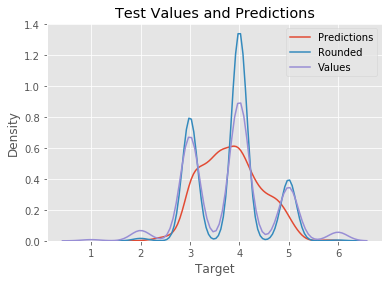

In [46]:
final_pred = gradient_boosted.predict(X_test)
rounded_pred = np.around(final_pred)
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(rounded_pred, label = 'Rounded')
sns.kdeplot(y_test, label = 'Values')
plt.xlabel('Target'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

Find hyperparameters of SVM with grid search.

In [146]:
# Define the grid of hyperparameters to search
hyperparameter_grid = {'gamma': ['scale', 'auto', 0.1, 1, 10], 'C': [1, 10, 1000]}
# Create the model to use for hyperparameter tuning
model = SVR()

# Set up the random search with 4-fold cross validation
grid_cv = GridSearchCV(estimator=model, param_grid=hyperparameter_grid, cv=5,
                       scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1, return_train_score=True)
grid_cv.fit(X, y)
print(grid_cv.best_estimator_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 10.2min finished


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [49]:
svm = SVR(C = 10, gamma = 'scale')
train_mae, test_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the train set: MAE = %0.4f' % train_mae)
print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % test_mae)

Support Vector Machine Regression Performance on the train set: MAE = 0.4707
Support Vector Machine Regression Performance on the test set: MAE = 0.5286


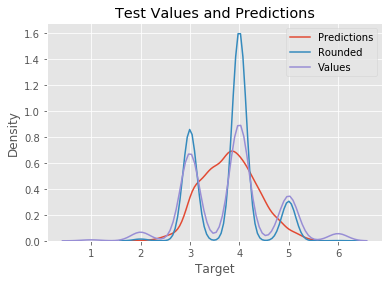

In [51]:
final_pred = svm.predict(X_test)
rounded_pred = np.around(final_pred)
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(rounded_pred, label = 'Rounded')
sns.kdeplot(y_test, label = 'Values')
plt.xlabel('Target'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

Try neural network.

In [70]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X, y, epochs=10, batch_size=1, verbose=1)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(test_acc)

Epoch 1/10
3892/3892 [==============================] - 15s 4ms/step - loss: 1.1844 - mean_absolute_error: 0.7641
Epoch 2/10
3892/3892 [==============================] - 14s 4ms/step - loss: 0.5771 - mean_absolute_error: 0.6032
Epoch 3/10
3892/3892 [==============================] - 14s 4ms/step - loss: 0.5579 - mean_absolute_error: 0.5905
Epoch 4/10
3892/3892 [==============================] - 14s 4ms/step - loss: 0.5429 - mean_absolute_error: 0.5823
Epoch 5/10
3892/3892 [==============================] - 14s 4ms/step - loss: 0.5369 - mean_absolute_error: 0.5769
Epoch 6/10
3892/3892 [==============================] - 14s 4ms/step - loss: 0.5356 - mean_absolute_error: 0.5748
Epoch 7/10
3892/3892 [==============================] - 15s 4ms/step - loss: 0.5279 - mean_absolute_error: 0.5699
Epoch 8/10
3892/3892 [==============================] - 15s 4ms/step - loss: 0.5278 - mean_absolute_error: 0.5715
Epoch 9/10
3892/3892 [==============================] - 14s 4ms/step - loss: 0.5257 - me

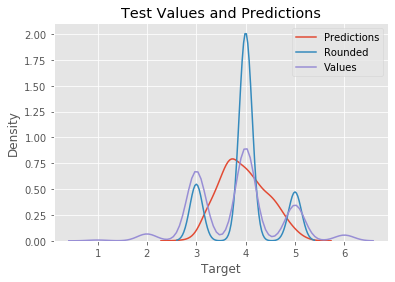

In [75]:
final_pred = model.predict(X_test)
rounded_pred = np.around(final_pred)
sns.kdeplot(final_pred[:,0], label = 'Predictions')
sns.kdeplot(rounded_pred[:,0], label = 'Rounded')
sns.kdeplot(y_test, label = 'Values')
plt.xlabel('Target'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

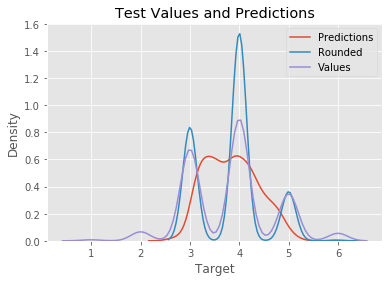

In [82]:
final_pred = random_forest.predict(X_test)
rounded_pred = np.around(final_pred)
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(rounded_pred, label = 'Rounded')
sns.kdeplot(y_test, label = 'Values')
plt.xlabel('Target'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

The best results were using gradient boosting algorithms. Go submit results on true test data.

In [86]:
df = pd.read_csv('TEST.csv', sep=',')
df

,Index,Type,Alcohol,Density,Nitrogen,pH,Sugar,A,B,C,D,Di,E,H,S,U,V
0,5600,white_wine,9.25,1.01,5.72,3.47,2.58,24.5,1.98,5.85,30.8,48.30,1.29,1.49,4.67,4.80,0.06
1,5601,white_wine,7.45,1.02,7.04,3.20,10.76,25.1,1.72,10.20,40.7,55.05,1.05,2.23,2.04,6.35,0.05
2,5602,white_wine,9.10,1.01,11.82,3.30,3.06,23.7,2.90,5.25,9.9,22.11,1.29,1.80,4.53,7.90,0.03
3,5603,red_wine,7.90,1.02,3.96,3.51,2.11,24.9,7.39,1.05,7.7,18.07,1.09,5.64,5.26,0.85,0.38
4,5604,white_wine,7.65,1.02,6.76,3.27,12.65,24.7,2.64,8.10,67.1,85.00,1.26,2.48,3.36,7.83,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,6385,red_wine,8.20,1.02,11.40,3.80,2.49,24.9,11.68,0.00,16.5,25.25,1.11,4.90,6.57,1.30,0.01
786,6386,red_wine,8.25,1.02,8.59,3.56,6.19,23.3,7.39,4.65,6.6,9.18,1.44,4.59,6.72,2.15,0.19
787,6387,white_wine,8.35,1.02,2.08,3.21,6.86,26.5,1.85,5.40,12.1,25.13,1.56,1.55,2.34,4.20,0.01
788,6388,red_wine,7.75,1.02,8.01,3.48,7.91,27.9,6.80,6.15,31.9,40.36,0.93,4.77,5.11,5.15,0.01


c:\users\botinovk\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


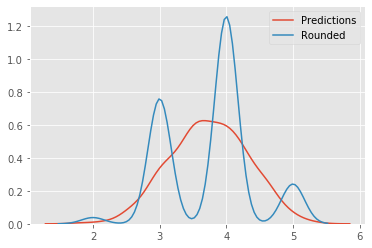

In [117]:
from numpy import savetxt
X_train = np.array(pd.read_csv('TEST.csv', sep=',',header=0))
X_train = X_train[:,1:]
X_train = np.delete(X_train, np.s_[10], 1)
df = pd.DataFrame(X_train)
df.columns = ['Type','Alcohol','Density','Nitrogen','pH','Sugar','A','B','C','D','E','H','S','U','V']
X_train = np.delete(X_train, np.s_[0], 1)
X_train = np.column_stack((X_train, np.array(pd.get_dummies(df['Type']))))
for i in range(0, 790):
    for j in range(0, 14):
        X_train[i, j] = np.cbrt(X_train[i, j])
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
imputer = Imputer(strategy='median')
imputer.fit(X_train)
X_train = imputer.transform(X_train)
final_pred = gradient_boosted.predict(X_train)
rounded_pred = np.around(final_pred)
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(rounded_pred, label = 'Rounded')
A = np.arange(5600, 5600+790)
A = np.reshape(A, (A.shape[0], 1))
rounded_pred = np.reshape(rounded_pred, (rounded_pred.shape[0], 1))
A = np.append(A, rounded_pred, axis=1)
A = A.astype(int)
A = np.append([['Index', 'Target']], A, axis=0)
savetxt('submit.csv', A, delimiter=',', fmt='%s')